In [1]:
import urllib.request
import json
import numpy as np
import pandas as pd

In [2]:
data_url = 'https://raw.githubusercontent.com/KU81-ComSci-ProjectEnd-GameCard/main/master/Predictor/data/processed_data/quality_run8k.json'
json_data = list()
with urllib.request.urlopen(data_url) as url:
    run_js = json.loads(url.read().decode())
run = pd.DataFrame(run_js)

In [3]:
run.loc[ run.master_deck.apply(len) > 50].count().count()
### only 51 run from 8k that have deck len > 50 mark as noise

51

In [4]:
rows_to_drop = run[run.master_deck.apply(len) > 50].index
run = run.drop(rows_to_drop)

In [5]:
decks = run.master_deck.tolist()

In [6]:
def upgrade_lst(lst):
  new_lst = list()
  for item in lst:
    if(item != 'Searing Blow'):
      new_lst.append(item+'+1')
  return new_lst
    
def get_ALL_CARD():
  IC_ATTACK_CARDS = ["Strike_R", "Bash", "Anger", "Body Slam", "Clash", "Cleave", "Clothesline", "Headbutt", "Heavy Blade", "Iron Wave", "Perfected Strike", "Pommel Strike", "Sword Boomerang", "Thunderclap", "Twin Strike", "Wild Strike", "Blood for Blood", "Carnage", "Dropkick", "Hemokinesis", "Pummel", "Rampage", "Reckless Charge", "Searing Blow", "Sever Soul", "Uppercut", "Whirlwind", "Bludgeon", "Feed", "Fiend Fire", "Immolate", "Reaper"]
  IC_SKILL_CARDS = ["Defend_R", "Armaments", "Flex", "Havoc", "Shrug It Off", "True Grit", "Warcry", "Battle Trance", "Bloodletting", "Burning Pact", "Disarm", "Dual Wield", "Entrench", "Flame Barrier", "Ghostly Armor", "Infernal Blade", "Intimidate", "Power Through", "Rage", "Second Wind", "Seeing Red", "Sentinel", "Shockwave", "Spot Weakness", "Double Tap", "Exhume", "Impervious", "Limit Break", "Offering"]
  IC_POWER_CARDS = ["Combust", "Dark Embrace", "Evolve", "Feel No Pain", "Fire Breathing", "Inflame", "Metallicize", "Rupture", "Barricade", "Berserk", "Brutality", "Corruption", "Demon Form", "Juggernaut"]
  IRONCLAD_CARDS = IC_ATTACK_CARDS + IC_SKILL_CARDS + IC_POWER_CARDS

  COLORLESS_CARDS = ["Dramatic Entrance", "Flash of Steel", "Mind Blast", "Swift Strike", "HandOfGreed", "Bite", "Expunger", "Ritual Dagger", "Shiv", "Smite", "Through Violence", "Bandage Up", "Blind", "Dark Shackles", "Deep Breath", "Discovery", "Enlightenment", "Finesse", "Forethought", "Good Instincts", "Impatience", "Jack Of All Trades", "Madness", "Panacea", "PanicButton", "Purity", "Trip", "Apotheosis", "Chrysalis", "Master of Strategy", "Metamorphosis", "Secret Technique", "Secret Weapon", "The Bomb", "Thinking Ahead", "Transmutation", "Violence", "Apparition", "Beta", "Insight", "J.A.X.", "Miracle", "Safety", "Magnetism", "Mayhem", "Panache", "Sadistic Nature", ]

  CURSE_CARDS = ["AscendersBane", "Clumsy", "Curse of the Bell", "Decay", "Doubt", "Injury", "Necronomicurse", "Normality", "Pain", "Parasite", "Pride", "Regret", "Shame", "Writhe"]
  return IRONCLAD_CARDS + COLORLESS_CARDS + CURSE_CARDS + upgrade_lst(IRONCLAD_CARDS) + upgrade_lst(COLORLESS_CARDS)

vocab = get_ALL_CARD()

In [7]:
value_to_index = dict( zip(vocab , range(0,len(vocab))))
index_to_value = dict( zip(range(0,len(vocab)),vocab ))

In [8]:
deck_indices = [[value_to_index[c] for c in deck] for deck in decks]

In [9]:
from keras.preprocessing.sequence import pad_sequences

In [10]:
max_len = max(len(lst) for lst in deck_indices)
deck_indices_padded = pad_sequences(deck_indices, maxlen=max_len)

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Flatten , Reshape

In [12]:
vocab_size = 257  # Number of unique tokens
embedding_dim = 20  # Dimension of the embedding vectors
input_length = 50  # Length of input sequences

input_layer = Input(shape=(input_length ,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedding  = embedding_layer(input_layer) 
flattened = Flatten()(embedding)

encoded = Dense(100, activation='relu')(flattened)

decoded = Dense(input_length * embedding_dim, activation='sigmoid')(encoded)
decoded_reshaped = Reshape((input_length, embedding_dim))(decoded)

autoencoder = Model(input_layer, decoded_reshaped)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}: loss = {logs["loss"]:.4f}')

epoch_logger = EpochLogger()
early_stopping = EarlyStopping(monitor='loss', patience=5)

In [14]:
autoencoder.fit(deck_indices_padded, np.random.rand(7978, input_length, embedding_dim), epochs=8000, verbose=0,callbacks=[epoch_logger ,early_stopping])

Epoch 100: loss = 0.6861
Epoch 200: loss = 0.6857


In [15]:
embedding_matrix = embedding_layer.get_weights()[0]

In [16]:
embedding_matrix.shape

(257, 20)

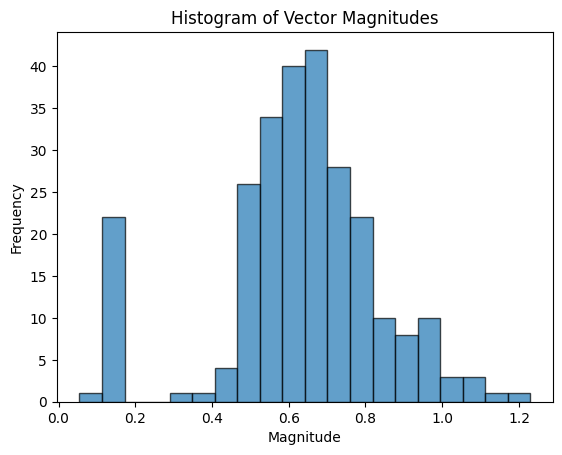

In [19]:
magnitudes = np.linalg.norm(embedding_matrix, axis=1)

# Plot histogram of magnitudes
plt.hist(magnitudes, bins='auto', edgecolor='black', alpha=0.7)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Vector Magnitudes')
plt.show()

In [21]:
card_vectors = dict( zip(vocab,embedding_matrix ))

In [22]:
from joblib import dump
import os

In [23]:
save_path = os.path.join('matrix_data', 'cardVecAuto_8k_20dim.joblib')

In [24]:
dump(card_vectors, save_path)

['matrix_data\\cardVecAuto_8k_20dim.joblib']

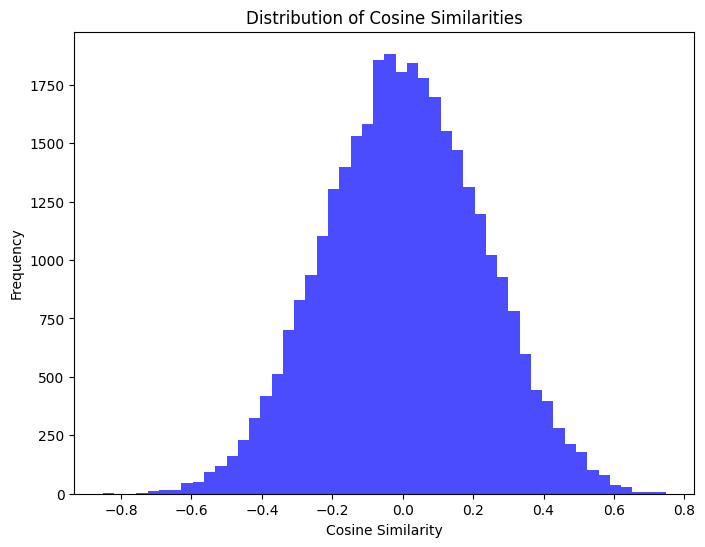

In [30]:
cosine_sim_matrix = cosine_similarity(embedding_matrix)
cosine_sim_values = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]

# Plot the distribution of cosine similarities
plt.figure(figsize=(8, 6))
plt.hist(cosine_sim_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [32]:
cardKmean = KMeans(n_clusters=10, random_state=10,n_init= 50)
cardK = cardKmean.fit_predict(embedding_matrix)

In [33]:
from collections import Counter
Counter(cardK)

Counter({3: 63, 6: 28, 7: 26, 4: 24, 1: 24, 8: 23, 2: 20, 9: 18, 0: 16, 5: 15})

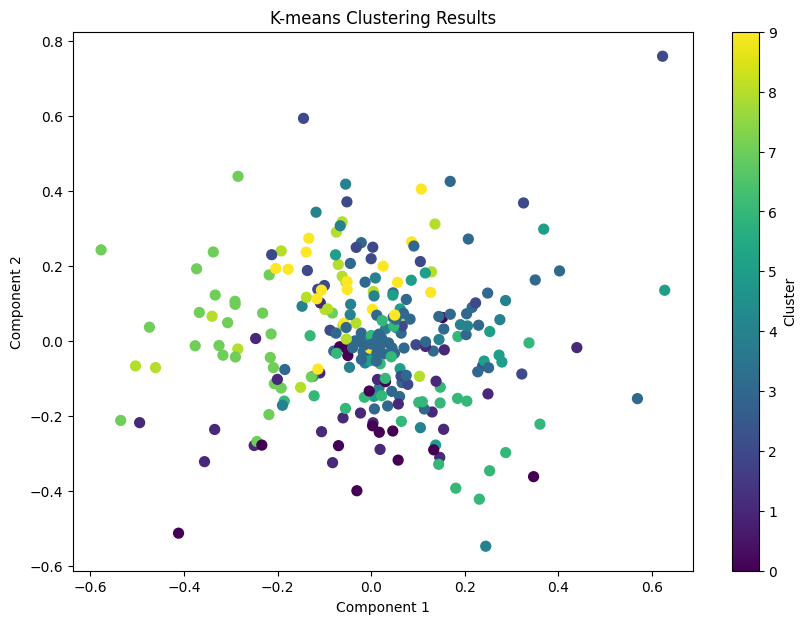

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Assuming cardVect is a numpy array with shape (257, 20)
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_matrix)

plot_data = pca_result

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(plot_data[:, 0], plot_data[:, 1], c=cardK, cmap='viridis', marker='o', s=50)
plt.colorbar(label='Cluster')
plt.title('K-means Clustering Results')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

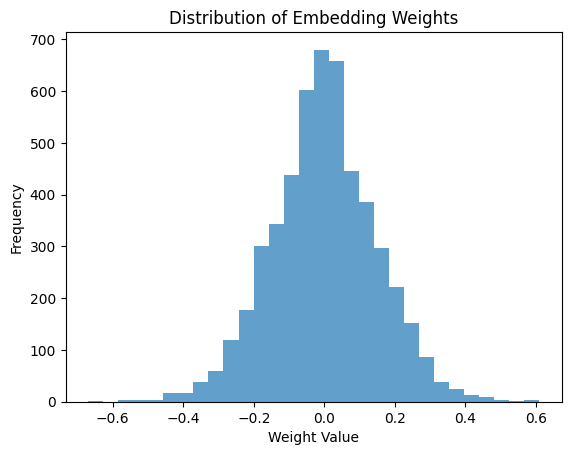

In [36]:
plt.hist(embedding_matrix.flatten(), bins=30, alpha=0.7)
plt.title('Distribution of Embedding Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

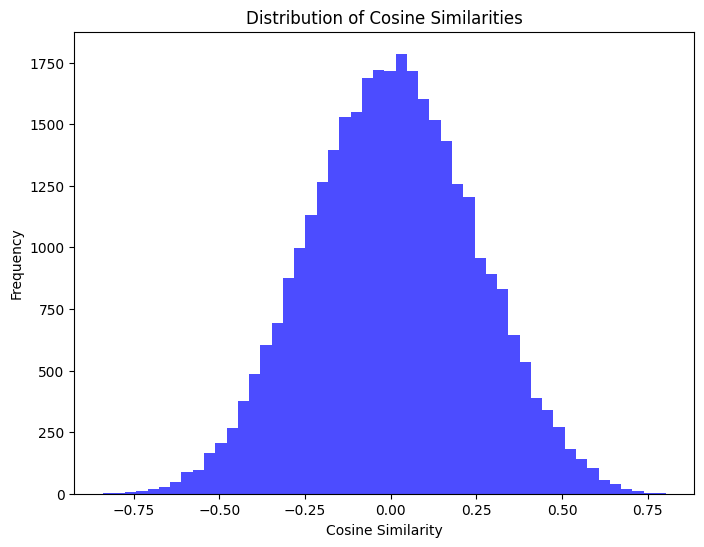

In [38]:

cosine_sim_matrix2 = cosine_similarity(cosine_sim_matrix)

cosine_sim_values = cosine_sim_matrix2[np.triu_indices_from(cosine_sim_matrix2, k=1)]

# Plot the distribution of cosine similarities
plt.figure(figsize=(8, 6))
plt.hist(cosine_sim_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()